In [26]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import csv
import time
from scipy.stats import pearsonr
from flopy.utils.sfroutputfile import SfrFile

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.tree import ExtraTreeRegressor

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

import importlib
import treeFuncs
from treeFuncs import trainAndEvaluateModel 
from treeFuncs import metrics
from scipy import stats


modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput/transientDrawdown"
modws= "D:/mfoutput/transientSeasons"

### Bring in data from MODFLOW files
First code block brings in the saved outputs (flows) from MODFLOW jupyter notebook and the parameters 
We set the number of stress periods we want to keep throughout the rest of the analysis (currently we take all of them so for constant pumping = 5, seasonal pumping = 21

In [27]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio','Pumping Rate']

# load output from modflow simulations
outputdf = pd.read_csv('mf_notebooks/TransOutputStpSteadyPumpTest9.csv') 
outputdf = pd.read_csv('mf_notebooks/TransOutputStpSeasonsTest9.csv') #output

#load parameters
sampling = np.loadtxt("mf_notebooks/ModflowParams8-1000Test4.txt") 
#print(sampling)
pardf = pd.DataFrame(sampling, columns = col_names)

outputdf = outputdf[['simnum','Qout','reach','Stp']].reset_index() #only keep the cols we need

#Drawdown scenario steps
numTS = 5 #number of time steps to keep from the end
stps = 5 - numTS

#Seasonal Scenario Steps
numTS = 21 #number of time steps to keep from the end
stps = 21 - numTS

StrPer = [i+1 for i in range(stps, stps+numTS)]
print(StrPer)
outputdf = outputdf[outputdf['Stp'] > stps].set_index(['Stp','simnum','reach']) #grab data from the last 5 stress periods and set index to simulation
simindex = outputdf.index.get_level_values('simnum').unique()
timestepidx = outputdf['index'].unique()
idx = pd.IndexSlice

pardf = pardf.iloc[simindex]
outputdf = outputdf.drop('index', axis=1).unstack('reach')
print(outputdf.shape)

outputdf = outputdf.droplevel(0, axis=1)
display(outputdf)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
(16969, 50)


reach          1        2       3        4        5        6        7   \
Stp simnum                                                               
1   1       100.0  100.210  304.08  629.670  1041.20  1517.90  2046.30   
    2       100.0    0.000  123.19  423.280   823.77  1294.30  1816.40   
    4       100.0   82.431  366.26  793.270  1314.00  1902.20  2541.10   
    5       100.0    0.000    0.00   56.753   252.00   531.28   872.73   
    6       100.0   38.315  299.94  708.980  1216.10  1796.70  2437.00   
...           ...      ...     ...      ...      ...      ...      ...   
21  994     100.0    0.000    0.00   96.350   340.91   671.30  1066.20   
    996     100.0    0.000    0.00  129.150   392.86   740.04  1151.40   
    997     100.0  123.850  365.45  732.540  1186.30  1704.40  2271.90   
    998     100.0    0.000  191.78  542.530   990.55  1507.60  2075.70   
    999     100.0    0.000   78.37  269.840   542.37   876.47  1258.60   

reach           8       9       10  ...       41       42       43       44  \
Stp simnum                          ...                                       
1   1       2617.5  3228.0  3876.3  ...  13019.0  13142.0  13250.0  13341.0   
    2       2376.8  2965.7  3576.6  ...  13237.0  13369.0  13486.0  13584.0   
    4       3218.9  3928.6  4669.1  ...  15361.0  15498.0  15619.0  15720.0   
    5       1264.7  1703.6  2196.3  ...   9356.1   9465.6   9561.8   9642.9   
    6       3131.9  3891.1  4758.8  ...  14040.0  14161.0  14268.0  14358.0   
...            ...     ...     ...  ...      ...      ...      ...      ...   
21  994     1516.2  2025.0  2627.1  ...   7160.8   7207.3   7251.2   7290.0   
    996     1618.9  2149.2  2781.1  ...   5878.3   5892.6   5908.5   5924.1   
    997     2878.7  3519.1  4190.0  ...   9857.6   9909.7   9960.2  10005.0   
    998     2682.7  3319.8  3984.6  ...  12690.0  12801.0  12901.0  12986.0   
    999     1678.8  2129.6  2604.9  ...   8128.4   8188.8   8245.2   8294.4   

reach            45       46       47       48       49       50  
Stp simnum                                                        
1   1       13413.0  13463.0  13489.0  13483.0  13421.0  13421.0  
    2       13660.0  13711.0  13729.0  13701.0  13554.0  13554.0  
    4       15800.0  15854.0  15876.0  15853.0  15734.0  15734.0  
    5        9706.6   9750.3   9770.5   9761.0   9687.3   9687.3  
    6       14430.0  14482.0  14512.0  14513.0  14444.0  14444.0  
...             ...      ...      ...      ...      ...      ...  
21  994      7321.2   7342.1   7349.8   7339.2   7269.6   7269.6  
    996      5937.3   5945.6   5946.4   5934.5   5870.5   5870.5  
    997     10040.0  10061.0  10064.0  10040.0   9962.8   9962.8  
    998     13052.0  13096.0  13110.0  13081.0  12943.0  12943.0  
    999      8332.9   8356.9   8361.8   8340.0   8270.1   8270.1  

[16969 rows x 50 columns]

### Removing zero flow simulations 

From our definition of 'non-behavioral' - these are simulations that are dry essentially all the time. 
We find the wettest reach in the last time period and then remove any simulations that are dry. In the steady state scenario, this was several but in the transient this is usually just a few or none at all.

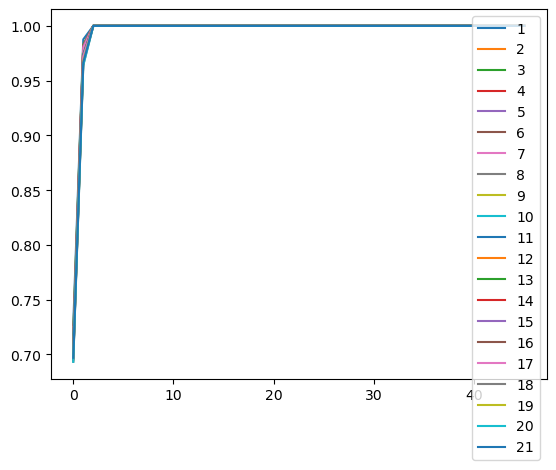

10
(808, 50)
(808,)


In [28]:
#Getting rid of ensembles with 0 flow
rn = 25

for i in StrPer:
    ReachQdf = outputdf.xs(i,level='Stp')

    numgrz = [np.sum(ReachQdf[k] > 0) / len(ReachQdf.index) for k in range(1,51)] 
   # print(numgrz.index(max(numgrz[2:])))
    plt.plot(numgrz[2:48], label=i)
    #print(ReachQdf.shape)
plt.legend()
#print(numgrz.index(max(numgrz)))
plt.show()
#print(ReachQdf.index)

rn_highest = 10#numgrz.index(max(numgrz[2:])) #find reach with greatest number of wet ensembles 
#ReachQdf = ReachQdf[ReachQdf[rn_highest] > 0]
print(rn_highest)
print(ReachQdf.shape)

#New way of pulling out simulations that are dry using multi-level index
idx = pd.IndexSlice #makes slicing multilevel indexs easier
HighRn = outputdf.loc[idx[StrPer[-1],:],rn_highest] #get a slice of the highest reach Qout (note in some instances the 0 stp had more sims so only lookng at last stp)
grtzSims = HighRn[HighRn > 0].index.get_level_values('simnum').unique().values #greater than zero simulations grtzSims
print(grtzSims.shape)

RevisedOutputdf = outputdf.loc[idx[:,grtzSims,:] , :]
#display(RevisedOutputdf)
#display(outputdf)
pardf = pardf.loc[grtzSims]

# for l in StrPer:
#     LastStpQdf = outputdf.xs(l,level='Stp')
#     for i in LastStpQdf.index:
#         LastStpQdf.loc[i].plot(title="Streamflows for Stress Period " + str(l))
#     plt.show()

## Now for the Wells

In [29]:
#load in Ibound and find active cells in model - then put it into a list of well locations
ibound = np.loadtxt('base/ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T

#well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_head = np.empty((all_well_loc.shape[0], len(grtzSims),numTS))

print(well_head.shape)

(2012, 808, 21)


In [5]:
# #Cell block for test head object out put - can ignore 

# modelname = "ScenarioSfr750Seasons_"+str(simindex[0])
# headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
# head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
# print(head.shape)
# print(head[::30,21,32][-6:])
# headtimes = np.array(headobj.get_times())
# print(headtimes)

# print(headtimes[::30])
# print(len(headtimes[::30]))

# headts = headobj.get_ts([(0,21,32)])
# #headts[10:,0] = (headts[10:,0] / 6) * 50  *2
# print(headts[::30][-numTS:].astype('int'))
# print(headobj.get_ts([(0,21,32)])[::30,1][-numTS:].astype('int'))


# print(len(headts))
# headstp = np.divmod(np.arange(len(headts)-10),30*2)[0]+1

# plt.plot(headts[::30,1])
# plt.show()
# plt.plot(headts[:,1])

In [30]:
#Get Head data for All active wells

#previously used the error list from the modflow output now just use the greater than zero sim list from above (grtzSims)
# error_list = np.loadtxt('mf_notebooks/ErrorSeasons_Sfr1000Test9.txt')
# #print(error_list)
# #sampling = np.loadtxt("ModflowParams7-750Test12.txt")
# ss_well_head_df= pd.read_pickle('outputs/heads/WellHead_SS1000test9.pkl')
# n = ss_well_head_df.index.values
# n2 = np.setdiff1d(n, error_list[:,0].astype('int'))
# err = [0,3,8,16,32,52,53,60,64,65,74,76,79,89,90,95,96,102,108,113,115,146,147,159,163,165,168,175,185,189,219,227,228,230,232,236,258,260,270,274,282,284,285,286,287,292,298,302,305,307,308,311,312,317,320,324,325,333,335,344,347,369,373,383,386,396,400,414,421,433,438,439,440,452,459,463]
# error_list = np.asarray(error_list)
# n3 = np.setdiff1d(n2, err)

#modws= "D:/mfoutput/transientSeasons"
#well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))


well_error_sim = []


for j, i in enumerate(grtzSims):
    modelname = "ScenarioSfr1000SeasonsTest9_"+str(i)
    #modelname = "ScenarioSfr1000SteadyPumpTest9_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
#     for k in range(all_well_loc.shape[0]):
#         well_head[k][j][:] = headobj.get_ts([(0,int(all_well_loc[k][0]),int(all_well_loc[k][1]))])[::30,1][-numTS:] #complicated way of getting all the heads (numTS) by sampling every 30 of the head ts foreach well
#         if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
#                 well_error_sim.append(i)              
   # print(i)            
    head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
    for k in range(all_well_loc.shape[0]): #grabbing the last n Stress periods (-numTS)
           # well_head[k][j][:] = head[::30,int(all_well_loc[k][0]),int(all_well_loc[k][1])][-numTS:] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would 
           # Seasons only reports 5 times a stress period, versus the orignal 30 - above 
            #print(i,k, head[::5,int(all_well_loc[k][0]),int(all_well_loc[k][1])][-numTS:])
            well_head[k][j][:] = head[::5,int(all_well_loc[k][0]),int(all_well_loc[k][1])][-numTS:] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would 
           
        # well_head[k][j][1] = head[-1][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would  be 60
            if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
                well_error_sim.append(i)
print("Done Pulling Heads") 

## Delete out simulations where well head is twice the average
print(well_head.shape)
#print(well_head.transpose(1,0,2).reshape(len(simindex),well_head.shape[0]*numTS))
RevisedPardf = pardf.loc[~pardf.index.isin(np.unique(well_error_sim))]
#new_zone.head
well_head_df = pd.DataFrame(well_head.transpose(1,0,2).reshape(len(grtzSims),well_head.shape[0]*numTS),index=grtzSims)#, index = pardf.index) #put the wwells into an unput that has each stress period so now input os 4024 long
display(well_head_df)
print(len(well_head_df.index))

well_head_df.to_pickle('outputs/heads/Well_head_Seasons.pkl')
#RevisedPardf.to_pickle('params/Seasons_pardf.pkl')   
print(len(well_head_df.index))
print(RevisedPardf)

Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x000001EDF40A3E50>
Traceback (most recent call last):
  File "C:\Users\davem\anaconda3\lib\weakref.py", line 104, in remove
    self = selfref()
KeyboardInterrupt: 


FileNotFoundError: [Errno 2] No such file or directory: 'D:/mfoutput/transientSeasons/ScenarioSfr1000SeasonsTest9_1.hds'

In [31]:
#Only necessary if not running previous cell and just want to pull well_head_df from pkl or csv

#well_head_df = pd.read_pickle('outputs/heads/Well_head_drawdown.pkl')
well_head_df = pd.read_pickle('outputs/heads/Well_head_seasons.pkl')

#new_zone = pd.read_pickle('params/Drawdown_pardf.pkl')
#new_zone = pd.read_pickle('params/Seasons_pardf.pkl')

well_head = np.empty((all_well_loc.shape[0], len(grtzSims),numTS))
well_heads_loc = np.arange(all_well_loc.shape[0]*numTS).reshape((int(all_well_loc.shape[0]),numTS)) #splits the well head_df into subsets aplicable to the location (so we ahve numTS outputs)

wellnums_arr = np.arange(well_head.shape[0])
stps_arr = StrPer
column_idx = pd.MultiIndex.from_product([wellnums_arr.astype('str'), stps_arr],
                           names=['wellnum', 'Stp'])
well_head_df.columns = column_idx

display(well_head_df)

wellnum          0                                                         \
Stp             1          2          3          4          5          6    
1        97.951523  97.951523  97.951355  97.949776  97.943138  97.929054   
2        97.409843  97.407593  97.380470  97.222939  97.113945  96.973175   
4        98.836693  98.836655  98.836258  98.834305  98.825882  98.810081   
5        95.484581  95.483665  95.476204  95.429817  95.368050  95.300568   
6        98.521690  98.520332  98.502312  98.421638  98.324600  98.212936   
..             ...        ...        ...        ...        ...        ...   
994      96.052467  96.048630  95.949875  95.802208  95.750572  95.673859   
996      96.457344  96.457069  96.431923  96.402237  96.351128  96.301476   
997      98.632179  98.632195  98.632179  98.630310  98.620628  98.601807   
998      98.000191  98.000313  98.000053  97.997177  97.988396  97.976700   
999      96.582619  96.577530  96.505692  96.361046  96.325958  96.244789   

wellnum                                              ...       2011  \
Stp             7          8          9          10  ...         12   
1        97.907326  97.878929  97.845314  97.807922  ...  92.057251   
2        96.909035  96.816071  96.791855  96.730568  ...  91.512405   
4        98.787743  98.760933  98.731094  98.699837  ...  92.541389   
5        95.239746  95.183990  95.138565  95.098709  ...  90.329735   
6        98.115730  98.020462  97.945686  97.874588  ...  92.354317   
..             ...        ...        ...        ...  ...        ...   
994      95.673889  95.629196  95.648209  95.614456  ...  90.766602   
996      96.237816  96.181915  96.116798  96.062813  ...  91.192680   
997      98.574570  98.541313  98.503815  98.464035  ...  92.482582   
998      97.962166  97.947708  97.932549  97.918823  ...  91.969254   
999      96.256470  96.204300  96.233162  96.190910  ...  91.092499   

wellnum                                                                    \
Stp             13         14         15         16         17         18   
1        92.050194  92.043457  92.036774  92.030472  92.024246  92.018410   
2        91.513000  91.510696  91.511719  91.509735  91.511002  91.509201   
4        92.538925  92.536888  92.534683  92.532906  92.530952  92.529411   
5        90.326859  90.323273  90.321457  90.318779  90.317726  90.315689   
6        92.347969  92.339249  92.335320  92.328659  92.326462  92.321266   
..             ...        ...        ...        ...        ...        ...   
994      90.765755  90.766052  90.765434  90.765862  90.765320  90.765793   
996      91.170982  91.159348  91.140121  91.130821  91.113815  91.106613   
997      92.477867  92.473434  92.469086  92.465034  92.461090  92.457443   
998      91.968498  91.967995  91.967354  91.966980  91.966438  91.966148   
999      91.095673  91.092072  91.095413  91.091919  91.095322  91.091866   

wellnum                                   
Stp             19         20         21  
1        92.012650  92.007309  92.002045  
2        91.510605  91.508911  91.510391  
4        92.527687  92.526367  92.524849  
5        90.315170  90.313576  90.313431  
6        92.320297  92.316147  92.316040  
..             ...        ...        ...  
994      90.765282  90.765770  90.765266  
996      91.091560  91.086189  91.072838  
997      92.453896  92.450645  92.447479  
998      91.965683  91.965469  91.965080  
999      91.095291  91.091843  91.095276  

[808 rows x 42252 columns]

## Using Wells to predict stream Flow

In [32]:
# Since we changed the number of wells - use this for flow only outputs
#well_df = pd.DataFrame(new_well_head.transpose(), index = new_zone.index)

river_well_loc = np.where(all_well_loc[:,0] == 25)
#river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

CHBound_loc = np.where(all_well_loc[:,1] > 47) #
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)

#Added recently - seems as if we don't need to exclude the river row and last column anymore 
drop_locs = [[]]

AllWells = np.arange(all_well_loc.shape[0])

noRivWells = [str(i) for i in AllWells if i not in drop_locs[0]]
print(len(noRivWells))

well_head_noRiv = well_head_df.loc[:,idx[noRivWells,:]]  

well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])
#display(well_loc_df)
#print(well_head_noRiv.shape)
#display(well_head_noRiv)

2012


### Creating the head difference dataframe 

Also known as the residuals or "drawdown map"

In [45]:
#Creating the diff well heads by subtracting off the first steady state pumping period
#lastStp df is in name only and represents the heads at the designated stpNum
stpNum = 3

firstStp = well_head_noRiv.loc[:,idx[:,StrPer[0]]].droplevel(level=1,axis=1)
lastStp = well_head_noRiv.loc[:,idx[:,StrPer[stpNum]]].droplevel(level=1,axis=1)
print('First Stress Period Head Data')
#checking to see if it worked
display(firstStp)

diffStpHeads = firstStp.sub(lastStp)
diffStpHeads.columns = diffStpHeads.columns.astype('str') #have to do this for the trees to remember the wellnums
print('Head Difference Table')
display(diffStpHeads)

firstStpOutputs = RevisedOutputdf.loc[idx[StrPer[0],:],:].droplevel(level=0,axis=0)
lastStpOutputs = RevisedOutputdf.loc[idx[StrPer[stpNum],:],:].droplevel(level=0,axis=0)
diffOutputs = firstStpOutputs.sub(lastStpOutputs)
print('Flow Difference Table')
display(diffOutputs)

#setting to the diff
LastStpHeads = diffStpHeads.copy()
outputsdf = diffOutputs.copy() 

#corrmatrix = LastStpHeads.corr()

First Stress Period Head Data


wellnum,0,1,2,3,4,5,6,7,8,9,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
1,97.951523,97.793365,97.529785,97.206230,96.825447,96.506592,96.109390,95.648262,95.129517,94.554932,...,96.459366,96.141579,95.745361,95.285233,94.767532,94.193977,93.560753,92.981590,92.475281,92.111702
2,97.409843,97.246796,96.975204,96.642029,96.249374,95.904434,95.500450,95.038834,94.524040,93.960098,...,95.884865,95.540565,95.137283,94.676460,94.162529,93.599503,92.988663,92.422112,91.922989,91.563393
4,98.836693,98.668320,98.387093,98.040993,97.632469,97.266884,96.834969,96.340775,95.788658,95.182091,...,97.199142,96.834740,96.404099,95.911270,95.360611,94.755554,94.095367,93.485992,92.950432,92.565186
5,95.484581,95.342781,95.107521,94.820351,94.483162,94.202675,93.853340,93.448463,92.994019,92.492058,...,94.226807,93.946434,93.597107,93.192207,92.737762,92.235786,91.683632,91.176781,90.732277,90.412193
6,98.521690,98.360649,98.091904,97.761833,97.374664,97.095276,96.718269,96.260109,95.728645,95.126350,...,96.973206,96.695930,96.320831,95.864479,95.334740,94.734024,94.060730,93.447136,92.914955,92.535530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,96.052467,95.908264,95.668755,95.376251,95.033936,94.789162,94.458672,94.057449,93.592850,93.067642,...,94.753250,94.509323,94.179504,93.778854,93.314766,92.789978,92.203979,91.667870,91.201317,90.867714
996,96.457344,96.313530,96.074623,95.783012,95.443764,95.265244,94.988564,94.624786,94.179939,93.657585,...,95.155540,94.978691,94.703445,94.340912,93.897110,93.375587,92.779305,92.228073,91.746513,91.402107
997,98.632179,98.468048,98.194130,97.857277,97.460075,97.112663,96.692528,96.209862,95.669777,95.074615,...,97.053917,96.707664,96.288681,95.807243,95.268448,94.674606,94.022469,93.423744,92.898705,92.521156
998,98.000191,97.835930,97.561966,97.225403,96.828453,96.474876,96.059029,95.583557,95.052849,94.470703,...,96.433357,96.080650,95.665741,95.191307,94.661705,94.080727,93.448898,92.864006,92.349251,91.978653


Head Difference Table


wellnum,0,1,2,3,4,5,6,7,8,9,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
1,0.001747,0.002029,0.002563,0.003288,0.004250,0.004936,0.005997,0.007393,0.009102,0.011185,...,0.001350,0.001450,0.001617,0.001801,0.002014,0.002274,0.002541,0.002831,0.003120,0.003349
2,0.186905,0.195404,0.209442,0.226631,0.246971,0.264801,0.285835,0.309875,0.336586,0.365608,...,0.014732,0.015251,0.015854,0.016548,0.017319,0.018150,0.019035,0.019951,0.020813,0.021477
4,0.002388,0.002693,0.003265,0.004013,0.005020,0.005943,0.007164,0.008705,0.010612,0.012917,...,0.001457,0.001534,0.001633,0.001762,0.001923,0.002106,0.002304,0.002518,0.002731,0.002914
5,0.054764,0.058388,0.064507,0.072113,0.081261,0.088760,0.098389,0.109764,0.122696,0.137070,...,0.013245,0.013847,0.014626,0.015549,0.016579,0.017708,0.018929,0.020180,0.021378,0.022316
6,0.100052,0.105927,0.115761,0.127930,0.142387,0.152237,0.165886,0.182655,0.202141,0.224075,...,0.026894,0.027908,0.029388,0.031204,0.033310,0.035652,0.038200,0.040779,0.043243,0.045143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.250259,0.254616,0.261566,0.269821,0.279404,0.287560,0.297516,0.308899,0.321449,0.334991,...,0.044434,0.045410,0.046677,0.048157,0.049820,0.051628,0.053574,0.055489,0.057251,0.058571
996,0.055107,0.058105,0.063057,0.069046,0.075943,0.077431,0.080887,0.086021,0.092659,0.100685,...,0.021675,0.021706,0.022217,0.023125,0.024361,0.025887,0.027657,0.029564,0.031448,0.032951
997,0.001869,0.002243,0.002937,0.003868,0.005112,0.006195,0.007675,0.009560,0.011871,0.014648,...,0.000572,0.000671,0.000793,0.000938,0.001106,0.001312,0.001518,0.001740,0.001953,0.002121
998,0.003014,0.003410,0.004120,0.005035,0.006210,0.007286,0.008636,0.010262,0.012207,0.014458,...,0.000763,0.000824,0.000908,0.001007,0.001114,0.001244,0.001381,0.001518,0.001648,0.001762


Flow Difference Table


reach,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
simnum,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.351,6.860,10.710,15.00,19.70,25.20,31.3,38.4,46.6,...,1577.0,1618.0,1651.0,1677.0,1697.0,1711.0,1722.0,1727.0,1729.0,1729.0
2,0.0,0.000,18.210,32.310,46.37,61.00,76.50,93.1,110.8,129.7,...,1328.0,1368.0,1405.0,1437.0,1465.0,1488.0,1504.0,1516.0,1520.0,1520.0
4,0.0,3.181,6.500,10.090,14.10,18.40,23.30,28.6,34.8,41.6,...,1155.0,1190.0,1219.0,1242.0,1260.0,1274.0,1284.0,1289.0,1291.0,1291.0
5,0.0,0.000,0.000,12.466,22.31,32.06,42.29,53.4,65.6,79.6,...,955.4,985.5,1012.3,1035.9,1055.9,1072.1,1084.5,1092.9,1096.4,1096.4
6,0.0,12.712,25.760,39.710,54.80,71.20,89.30,109.4,132.4,160.0,...,1537.0,1583.0,1626.0,1662.0,1692.0,1718.0,1738.0,1751.0,1757.0,1757.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.0,0.000,0.000,21.720,36.74,50.86,65.00,79.7,95.8,114.4,...,642.7,658.3,671.4,683.2,694.2,702.4,708.9,713.6,715.1,715.1
996,0.0,0.000,0.000,12.580,21.93,31.31,41.50,52.7,66.2,83.3,...,909.2,936.1,959.5,978.7,994.2,1007.1,1016.7,1023.3,1026.3,1026.3
997,0.0,0.950,1.960,3.110,4.40,6.00,8.00,10.3,13.3,16.9,...,1226.0,1265.0,1296.0,1321.0,1339.0,1354.0,1362.0,1368.0,1369.0,1369.0


### Visualizing head values and correlations

In [46]:
corrmatrix = LastStpHeads.corr()

well num, well col, well row 

844 21 31


C:\Users\davem\AppData\Local\Temp\ipykernel_16712\1301083348.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


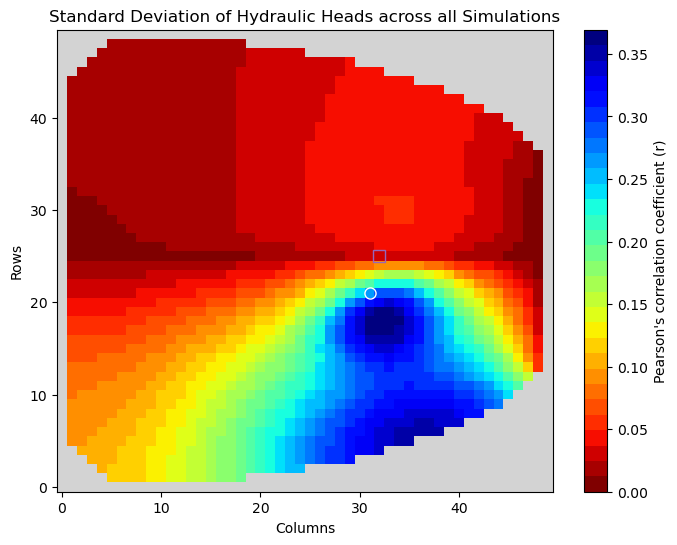

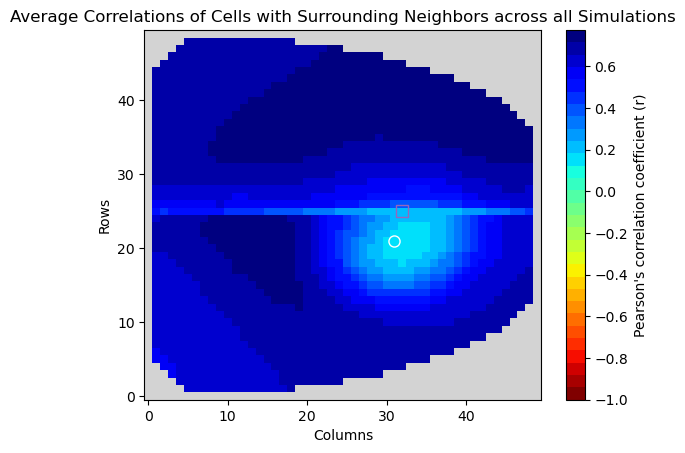

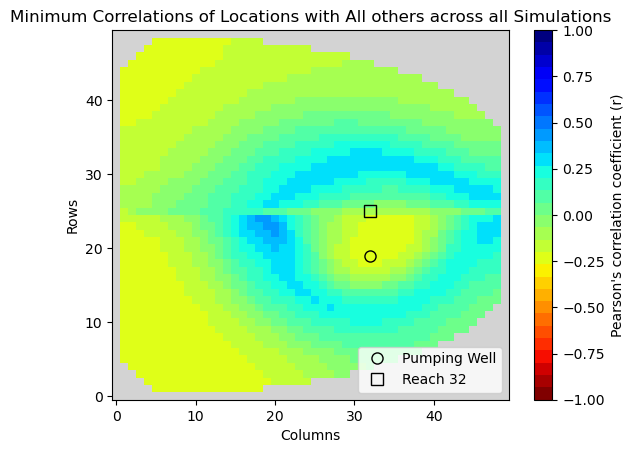

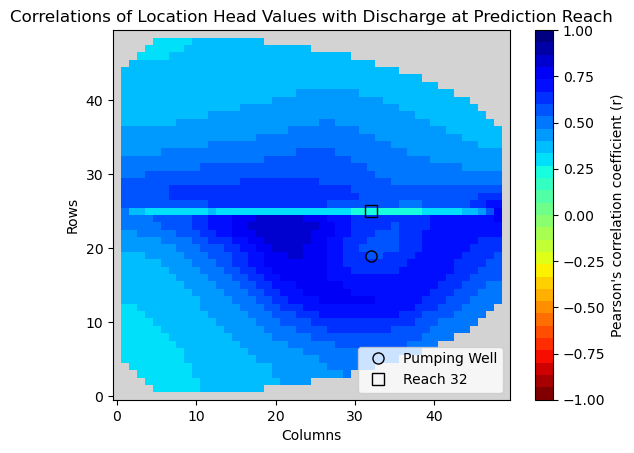

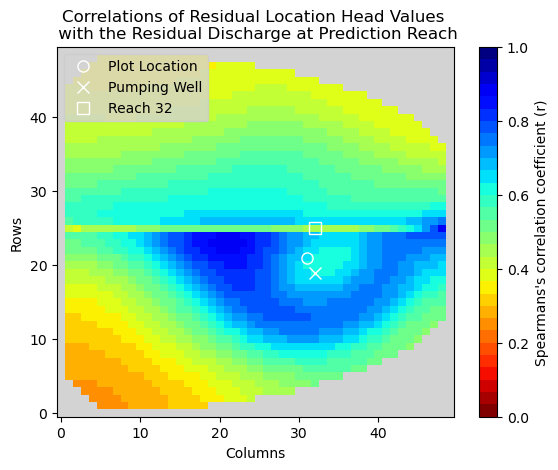

In [47]:
wn = 844
print("well num, well col, well row \n")
print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]))

ztop = np.genfromtxt('base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)


kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

# print(well_head_var)
wellmesh = np.ndarray((50,50))
wellmesh[:][:] = -1e30

wellmesh2 = wellmesh.copy()
mesh_feat_to_target = wellmesh.copy()
wellmesh_corr = wellmesh.copy()
minmesh = wellmesh.copy()
spearmans_feat_to_target = wellmesh.copy()

from spotpy.objectivefunctions import correlationcoefficient as r

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]

rn = 32

#LastStpHeads = well_head_df.loc[:,idx[:,StrPer[-1]]]

#outputs = RevisedOutputdf.loc[idx[StrPer[-1],:],rn].unstack('Stp')

outputs = outputsdf[rn]

for i in range(all_well_loc.shape[0]):
    
    wellmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = LastStpHeads[str(i)].std()
    mesh_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = r(outputs.values.flatten(),LastStpHeads[str(i)].values.flatten())
   # wellmesh2[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = LastStpHeads[str(i)].mean() - ztop[int(all_well_loc[i, 0]),int(all_well_loc[i, 1])]
    wellmesh_corr[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = corrmatrix[str(i)].mean()
    minmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = corrmatrix[str(i)].min()
    
    rho, p = stats.spearmanr(outputs.values.flatten(),LastStpHeads[str(i)].values.flatten())
    spearmans_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = rho


    
cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("lightgray")
river = np.ndarray((48,))
river[:] = 25
plt.figure(figsize=(8,6))

reach_label = "Reach " + str(rn)

plt.pcolormesh(KK,GG,wellmesh,cmap = cmap2,vmin=0, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(rn,25, marker="s", markersize=8, color="tab:purple", mfc='none', linestyle = "None", label=reach_label)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Standard Deviation of Hydraulic Heads across all Simulations')
plt.show()


plt.pcolormesh(KK,GG,wellmesh_corr,cmap = cmap2,vmin=-1, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(rn,25, marker="s", markersize=8, color="tab:purple", mfc='none', linestyle = "None", label=reach_label)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Average Correlations of Cells with Surrounding Neighbors across all Simulations')
plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')

# #plt.imshow(wellmesh, cmap='RdBu')

plt.pcolormesh(KK,GG,minmesh,cmap = cmap2,vmin=-1, vmax = 1, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(32,19, marker="o", markersize=8, color="k", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="k", mfc='none', linestyle = "None", label=reach_label)
plt.legend(loc='lower right')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Minimum Correlations of Locations with All others across all Simulations')
plt.show()

plt.pcolormesh(KK,GG,mesh_feat_to_target,cmap = cmap2, vmin = -1, vmax=1,shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(32,19, marker="o", markersize=8, color="k", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="k", mfc='none', linestyle = "None", label=reach_label)
plt.legend(loc='lower right')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Correlations of Location Head Values with Discharge at Prediction Reach')
plt.show()

plt.pcolormesh(KK,GG,spearmans_feat_to_target,cmap = cmap2,vmin=0, vmax=1, shading='nearest')
plt.colorbar(label = 'Spearmans\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')

plt.title('Correlations of Residual Location Head Values \n with the Residual Discharge at Prediction Reach')
#plt.title('Correlations of Location Head Values \n with Discharge at Prediction Reach')
plt.show()


In [102]:
#display(well_head_noRiv)

## Testing stacking all the stressperiods together to increase the sample sizes
# Stp_head_test_df = well_head_noRiv.copy()
# noRivWellsInt = [i for i in AllWells if i not in drop_locs[0]]

# column_idx = pd.MultiIndex.from_product([noRivWellsInt, stps_arr],
#                            names=['wellnum', 'Stp'])
# Stp_head_test_df.columns = column_idx
# # Stp_head_test_df.columns = Stp_head_test_df.columns.astype('str')
# #display(Stp_head_test_df)
# Stp_head_test_df = Stp_head_test_df.stack(level='Stp').reset_index(drop=True)
# display(Stp_head_test_df)
# output_test = RevisedOutputdf.swaplevel(0,1).sort_index(0)
# #display(RevisedOutputdf[25])
# output_test = output_test.reset_index(drop=True)
# #display(RevisedOutputdf.loc[idx[:,1],25])

# Stp_head_test_df.columns = Stp_head_test_df.columns.astype('str')

### Decision Tree Code

In [36]:
best_pars_dt = {'min_samples_split': 15, 'min_samples_leaf': 5, 'min_impurity_decrease': 15, 'max_leaf_nodes': 234, 'max_depth': 8, 'criterion': 'squared_error','random_state': 29}

#Previous
#best_pars_dt = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse', 'random_state':1}

In [37]:
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

random_state = 29

rn = 32
#strper_num = 0
#StrPer = [i+1 for i in range(stps, stps+numTS)]

# #take the last stress period (-1) - welldf columns are strings 
# SingleStpHeads = well_head_noRiv.loc[:,idx[:,StrPer[-1]]]
# SingleStpHeads.columns = SingleStpHeads.columns.droplevel('Stp').astype('str') #have to do this for the TreeRegressor to keep the wellnums

# outputs = RevisedOutputdf.loc[idx[StrPer[-1],:],rn].unstack('Stp')
# #display(outputs)
outputs = outputsdf[rn]

imp_df, metrics_df, impurity, Tree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, LastStpHeads, outputs, best_pars_dt, 0.2, n, random_state)  

#imp_df, metrics_df, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, Stp_head_test_df, outputs[rn], best_pars_dt, 0.2, n)  

print('Total time: ' + str(time.time()-t0))


Shape of Input Samples: (808, 2012)
Shape of Output Targets: (808,)
Total time: 1.7357172966003418


       bias        rmse         r       nse    lognse       kge
0 -0.665759  118.835062  0.990861  0.981025  0.984835  0.966536


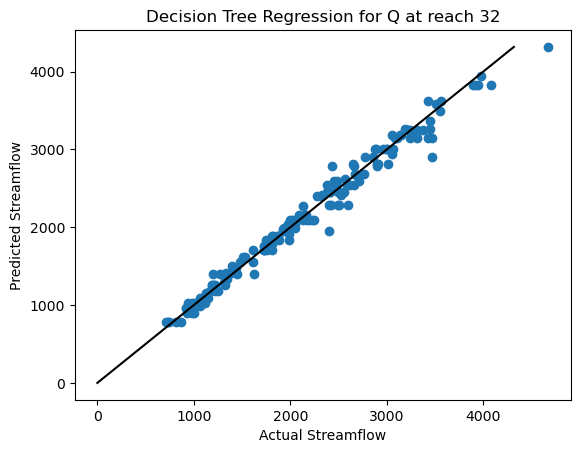

[0.7260686351680279, 0.10722591614311906, 0.10203126537565983]


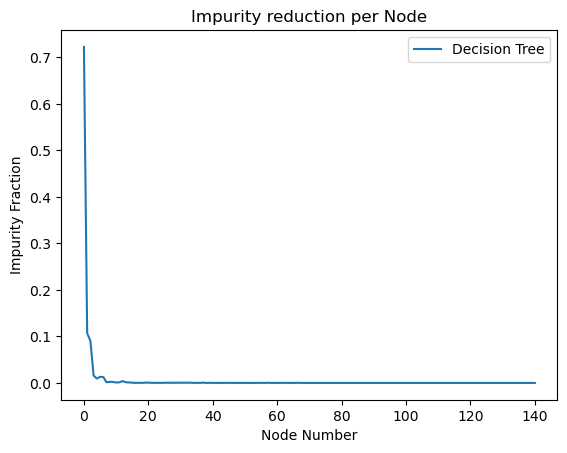

In [38]:
print(metrics_df)
# display(imp_df)
# test = imp_df.copy().T
#test.columns =Stp_head_test_df.columns
#test.columns = well_head_noRiv.columns
#test = pd.DataFrame(test.sum(axis = 0) / n)

#display(test)


# #imp_df.to_pickle('Drawdown_DT_Impdf.pkl')
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)
plt.show()

import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import quickEvalTree

impurity_df = pd.DataFrame(impurity).fillna(0)
avg_impurity = impurity_df.mean(axis = 0)

#print(Tree.max_features_)
#print(Tree.n_features_in_)
print(sorted(Tree.feature_importances_, reverse=True)[:3])
from treeFuncs import evalTree
imp_improv = quickEvalTree(Tree)

plt.plot(imp_improv, label = "Decision Tree")
#plt.plot(rand_imp_improv, label ="Random Tree")
#plt.plot(avg_rand_impurity, label ="Avg Random Tree")
plt.title('Impurity reduction per Node')
plt.ylabel('Impurity Fraction')
plt.xlabel('Node Number')
plt.legend()
#help(tree._tree.Tree)

## Random Feature Tree

Shape of Input Samples: (808, 2012)
Shape of Output Targets: (808,)
Total time: 17.52119493484497
bias        0.501819
rmse      232.565512
r           0.961181
nse         0.923159
lognse      0.923157
kge         0.951075
dtype: float64


Text(0.5, 1.0, 'Example Random Decision Tree Regression for Q at reach 32')

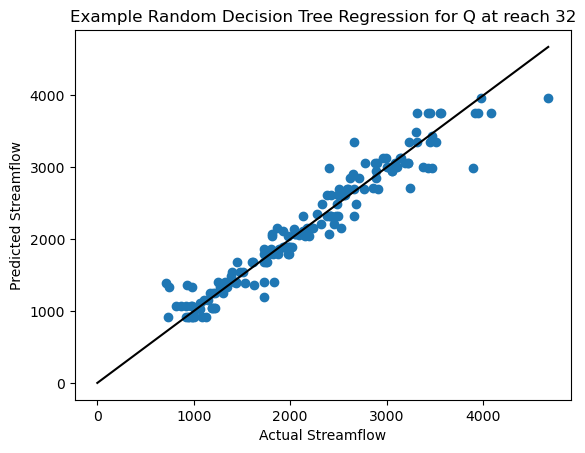

In [39]:
# RANDOM Feature Tree 
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()


#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
best_pars_dt_rand = {'splitter': 'best', 'max_features': 1, 'min_samples_split': 15, 'min_samples_leaf': 5, 'min_impurity_decrease': 15, 'max_leaf_nodes': 234, 'max_depth': 8, 'criterion': 'squared_error'}

#best_pars_dt_rand = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1, 'max_depth': 7, 'criterion': 'friedman_mse'}
    
n=100
imp_df_rand, metrics_df_rand, rand_impurity_list, randTree, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, LastStpHeads, outputs, best_pars_dt_rand, 0.2, n, random_state)  

#imp_df_rand, metrics_df_rand, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, Stp_head_test_df, output_test[rn], best_pars_dt_rand, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rand.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Random Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)
C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


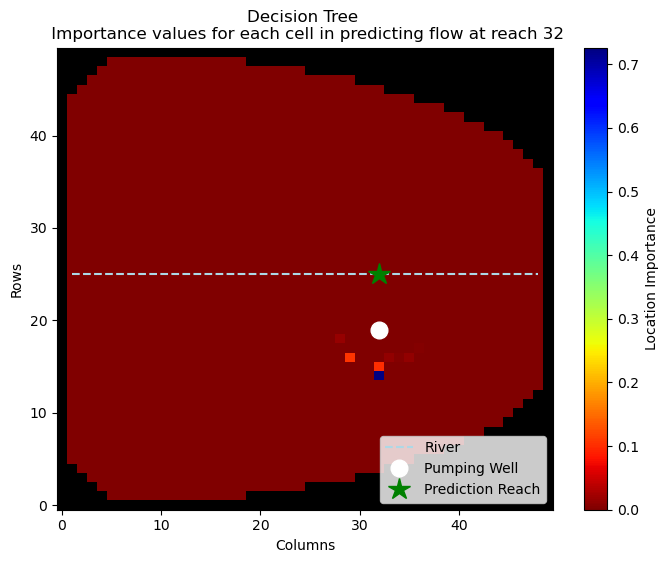

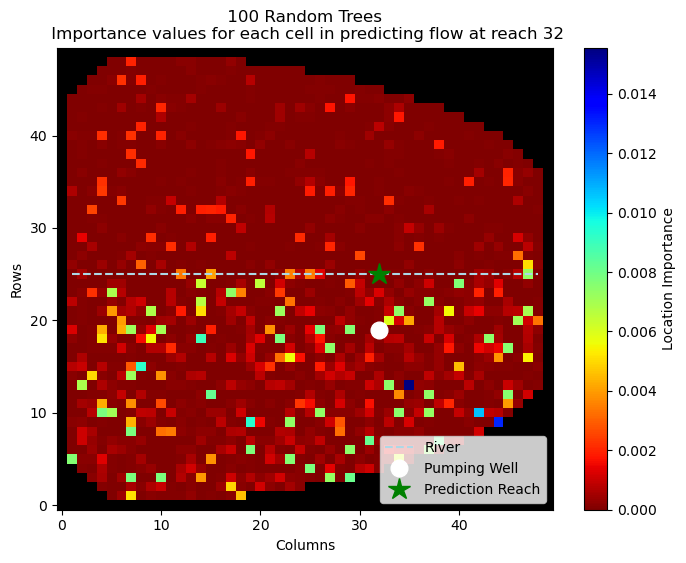

In [40]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1

title = 'Decision Tree \n Importance values for each cell in predicting flow at reach ' + str(rn)
#wellmesh_df = np.ndarray((len(StrPer),50,50))


#for k,i in enumerate(StrPer):
 #   wellmesh_df[k] = plotImportance(test.xs(i,level='Stp'),SingleStpHeads, well_loc_df,numTS,n,rn,title)
wellmesh_df = plotImportance(imp_df,LastStpHeads, well_loc_df,numTS,1,rn,title)

title_rand = ' 100 Random Trees \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_rand = plotImportance(imp_df_rand,LastStpHeads, well_loc_df,numTS,100,rn,title_rand)


62
         0         1         2         3         4         5         6    \
0   0.199069  0.245017  0.160062  0.006055  0.005621  0.026016  0.082754   
1   0.619028  0.027136  0.007778  0.001458  0.013483  0.000310  0.036805   
2   0.333611  0.059886  0.112646  0.011907  0.011126  0.022774  0.215905   
3   0.327460  0.323889  0.118917  0.004448  0.005385  0.009579  0.001363   
4   0.701353  0.026788  0.083407  0.003995  0.014121  0.000692  0.012552   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.633901  0.086935  0.024563  0.001928  0.007541  0.003626  0.003431   
96  0.543791  0.005178  0.018706  0.123300  0.002730  0.016051  0.003925   
97  0.630708  0.022536  0.012211  0.006115  0.052675  0.009874  0.001951   
98  0.693040  0.019555  0.019247  0.025247  0.035181  0.002019  0.001464   
99  0.219850  0.095959  0.251868  0.038554  0.001714  0.048004  0.001914   

         7         8         9    ...  149  150  151  152  153  154  155  156  \
0  

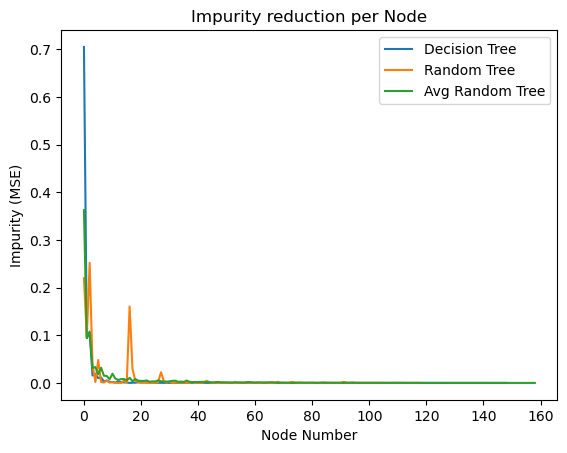

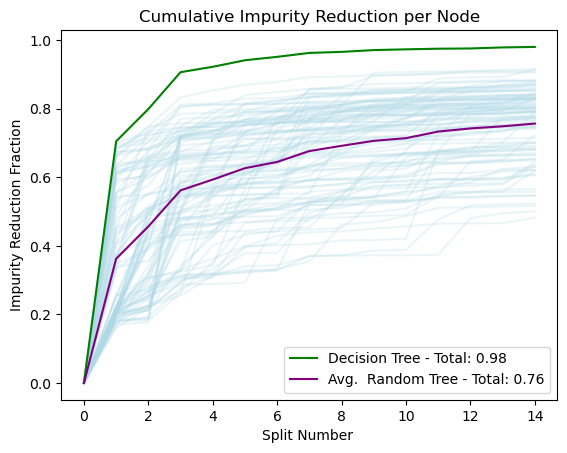

In [17]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import evalTree

impurity_df = pd.DataFrame(rand_impurity_list).fillna(0)
avg_rand_impurity = impurity_df.mean(axis = 0)

max_rand_idx = impurity_df.iloc[:,:2].sum(axis=1).idxmax()
print(max_rand_idx)
print(impurity_df)
max_rand_impurity = impurity_df.loc[max_rand_idx]

min_rand_idx = impurity_df.sum(axis = 1).idxmin()
min_rand_idx = impurity_df[0].idxmin()

min_rand_impurity = impurity_df.loc[min_rand_idx]
#display(impurity_df)
#print(Tree.max_features_)
#print(Tree.n_features_in_)
#print(sorted(randTree.feature_importances_, reverse=True)[:3])
#from treeFuncs import evalTree
rand_imp_improv = quickEvalTree(randTree)

plt.plot(imp_improv, label = "Decision Tree")
plt.plot(rand_imp_improv, label ="Random Tree")
plt.plot(avg_rand_impurity, label ="Avg Random Tree")
plt.title('Impurity reduction per Node')
plt.ylabel('Impurity (MSE)')
plt.xlabel('Node Number')
plt.legend()
#help(tree._tree.Tree)
plt.show()

#quick cumulative function that inserts 0 at beginning 
def cumImpurity(imp):
    nodes = 15
    return np.cumsum(np.insert(imp,0,0))[:nodes] #inserting 0 at the beginning - essentially to indicate the original impurity reduction (0)



dt_impurity_cumulative = cumImpurity(imp_improv)
#rand_impurity_cumulative = cumImpurity(rand_imp_improv)[:50]
avgrand_impurity_cumulative = cumImpurity(avg_rand_impurity.to_numpy())
#maxrand_impurity_cumulative = cumImpurity(max_rand_impurity.to_numpy())
minrand_impurity_cumulative = cumImpurity(min_rand_impurity.to_numpy())
x_nodes = np.arange(len(minrand_impurity_cumulative))
          
for i in range(100):
    single_impurity = cumImpurity(impurity_df.loc[i].to_numpy())
    plt.plot(single_impurity, color='lightblue', alpha = 0.25)
    
plt.plot(dt_impurity_cumulative, markersize = 4, color='g', label = "Decision Tree - Total: {:.2f}".format(np.max(dt_impurity_cumulative)))
#plt.plot(rand_impurity_cumulative, markersize = 4, marker= 'o', label ="Random Tree - Total: {:.2f}".format(np.max(rand_impurity_cumulative)))
plt.plot(avgrand_impurity_cumulative, markersize = 4, color='purple', label ="Avg.  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
#plt.fill_between(x_nodes,maxrand_impurity_cumulative, minrand_impurity_cumulative, alpha = 0.2, label ="Min and Max Random Tree")
#plt.plot(maxrand_impurity_cumulative, markersize = 4,marker='.', label ="Max  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
    
plt.title('Cumulative Impurity Reduction per Node')
plt.ylabel('Impurity Reduction Fraction')
plt.xlabel('Split Number ')
plt.xticks(minor=True)
plt.legend(loc='lower right')

## Gradient Boosting

In [18]:
#new pars - from DIFF analysis
best_pars_gr = {'subsample': 0.9, 'n_estimators': 225, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 15, 'max_leaf_nodes': 154, 'max_depth': 4, 'loss': 'huber', 'learning_rate': 0.11, 'criterion': 'friedman_mse'}

#best_pars_gr = {'subsample': 0.6, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 45, 'max_leaf_nodes': 52, 'max_features': 1.0, 'max_depth': 3, 'loss': 'squared_error', 'criterion': 'friedman_mse'}
#best_pars_gr = {'subsample': 0.5, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 6, 'loss': 'huber', 'criterion': 'friedman_mse'}

Shape of Input Samples: (922, 2012)
Shape of Output Targets: (922,)
Total time: 496.5479345321655
bias       0.142586
rmse      64.636242
r          0.996932
nse        0.993853
lognse     0.995762
kge        0.996617
dtype: float64


Text(0.5, 1.0, 'Gradient Boosting Tree Regression for Q at reach 32')

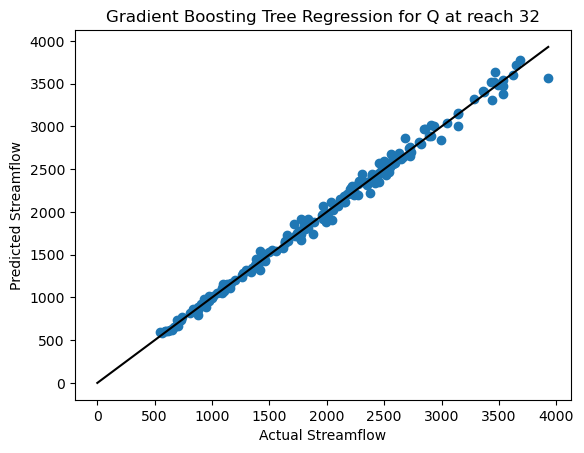

In [19]:
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

t0 = time.time()
n = 1

#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
    
#imp_df_gr, metrics_df_gr, y_test, y_pred = trainAndEvaluateModel(GradientBoostingRegressor, Stp_head_test_df, output_test[rn], best_pars_gr, 0.2, random_state)  

imp_df_gr, metrics_df_gr, gr_impurity, gr_tree, y_test, y_pred = trainAndEvaluateModel(GradientBoostingRegressor, LastStpHeads, outputs, best_pars_gr, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_gr.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Gradient Boosting Tree Regression for Q at reach " + str(rn)
plt.title(title)

# meshtitle = 'Gradient Boosting \n Importance values for each cell in predicting flow at reach ' + str(rn)

# wellmesh_gr = plotImportance(imp_df_gr,SingleStpHeads, well_loc_df,1,1,rn,meshtitle)

In [20]:
#gr_imp_df.to_pickle('Drawdown_GB_Impdf.pkl')
treeimp = pd.DataFrame(gr_tree.feature_importances_)
#display(treeimp)
topFeats = treeimp[0].nlargest(5)
topFeatLocs = Tree.feature_names_in_[topFeats.index]
display(topFeats)
display(topFeatLocs)
display(well_loc_df.loc[topFeatLocs.astype('int')])

display(imp_df_gr)
MostImp = []
for i in range(n):
    MostImp.append(int(imp_df_gr[i].idxmax()))

locs, counts = np.unique(MostImp,return_counts=True)
print(locs,counts)
display(well_loc_df.loc[locs])

508    0.257154
509    0.248459
553    0.105840
555    0.085562
507    0.079732
Name: 0, dtype: float64

array(['508', '509', '553', '555', '507'], dtype=object)

,0,1
508,14,31
509,14,32
553,15,28
555,15,30
507,14,30


,0
0,0.000000e+00
1,2.478668e-05
2,0.000000e+00
3,7.337805e-07
4,1.296263e-07
...,...
2007,1.229579e-06
2008,0.000000e+00
2009,0.000000e+00
2010,3.289409e-08


[508] [1]


,0,1
508,14,31


C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


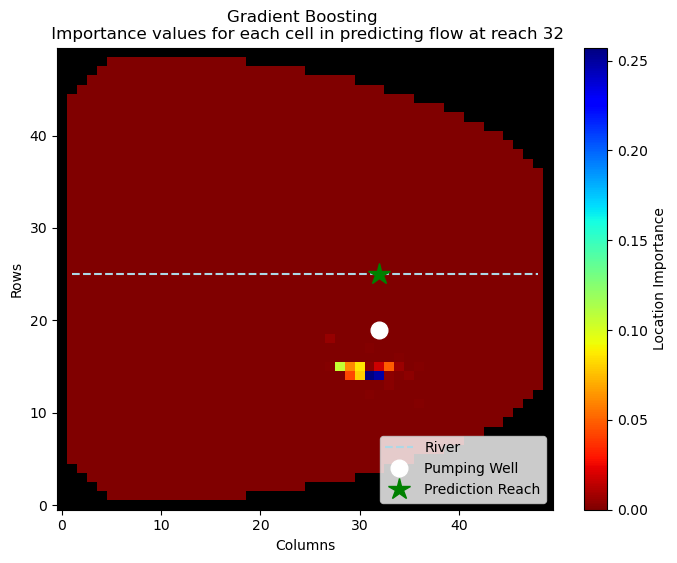

In [21]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
#n = 100

title = 'Gradient Boosting \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_gr = plotImportance(imp_df_gr,LastStpHeads, well_loc_df,1,1,rn,title)



## Random Forest 

In [22]:
#new best RF
best_pars_rf = {'n_estimators': 175, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 5, 'max_samples': 0.9, 'max_leaf_nodes': None, 'max_depth': 7, 'criterion': 'squared_error'}


#best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
#best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
#best_pars_rf = {'max_depth': 4, 'criterion' : 'absolute_error','min_impurity_decrease': 0.01}

Shape of Input Samples: (922, 2012)
Shape of Output Targets: (922,)
Total time: 404.04555225372314
bias       0.061345
rmse      75.823995
r          0.995762
nse        0.991541
lognse     0.993265
kge        0.994016
dtype: float64


Text(0.5, 1.0, 'Random Forest Regression for predicting Q at reach 32')

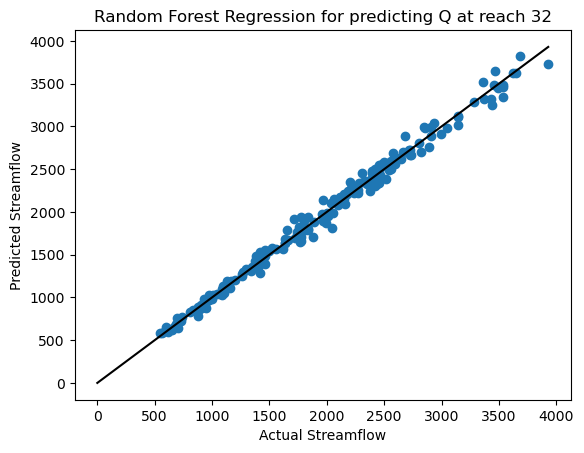

In [23]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n=1

#22, 27, 32, 37, 42  
rn = 32
outputs = outputsdf[rn]

#Splitter is random and max features is set to 1 (note that 1.0 is all in the new default all features in Sklearn so this is a little confusing)   
#imp_df_rf, metrics_df_rf, impurity_list, rf_Tree, y_test, y_pred = trainAndEvaluateModel(RandomForestRegressor, Stp_head_test_df, output_test[rn], best_pars_rf, 0.2, n, random_state)  
imp_df_rf, metrics_df_rf, impurity_list, rf_Tree, y_test, y_pred = trainAndEvaluateModel(RandomForestRegressor, LastStpHeads, outputs, best_pars_rf, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rf.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1

plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Random Forest Regression for predicting Q at reach " + str(rn)
plt.title(title)

In [24]:
#rf_imp_df.to_pickle('Drawdown_RF_Impdf.pkl')
# RF_rmse = round(metrics_df_rf.mean().loc['rmse'],2)
# print(RF_rmse)

display(imp_df_rf)
MostImp = []
for i in imp_df_rf.columns:
    MostImp.append(int(imp_df_rf[i].idxmax()))

locs, counts = np.unique(MostImp,return_counts=True)
print(locs,counts)
display(well_loc_df.loc[locs])
print(imp_df_rf.loc[str(locs[0])])
print(imp_df_rf.loc[str(701)])


,0
0,4.975296e-06
1,6.580715e-06
2,0.000000e+00
3,8.095156e-06
4,7.177023e-06
...,...
2007,3.832669e-07
2008,0.000000e+00
2009,6.869901e-07
2010,1.775504e-07


[508] [1]


,0,1
508,14,31


0    0.186445
Name: 508, dtype: float64
0    0.000129
Name: 701, dtype: float64


C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


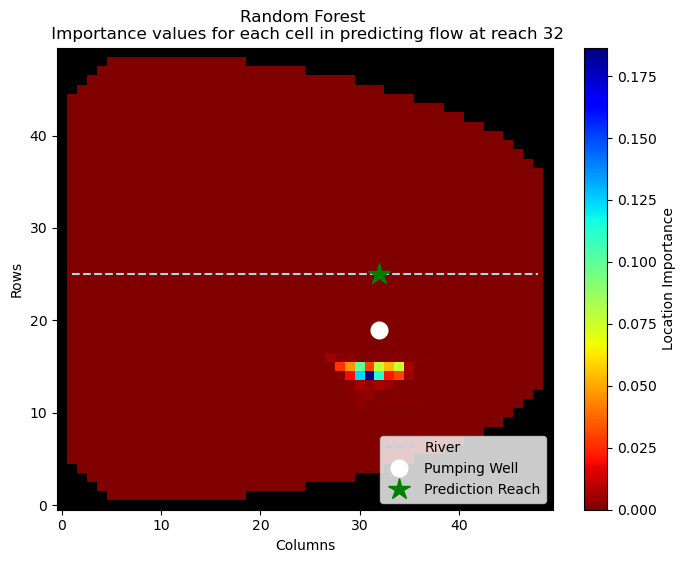

In [25]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
#n = 100

title = 'Random Forest \n Importance values for each cell in predicting flow at reach ' + str(rn)# + '\n RMSE: ' + str(RF_rmse)

wellmesh_rf = plotImportance(imp_df_rf,LastStpHeads, well_loc_df,numTS,n,rn,title)

In [ ]:
#set up the meshgrid   
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)



river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.01)
vmaxrf = np.max(wellmesh_rf)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_gr, wellmesh_gr < 0.01)
vmaxgr = np.max(wellmesh_gr)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_df, wellmesh_df < 0.01)
vmaxdt = np.max(wellmesh_df)

vmin = 0.01
# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128))))
print(colors)

mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = 1.5,vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmaxdt, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmaxrf, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmaxgr, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Drawdown Scenario \n Importance values for each cell in predicting flow at reach ' + str(rn) + ' for all 3 ML Methods')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.15,0.5,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Random Forest', 'Gradient Boosted','Decision Tree',''])
#plt.legend()

well num, well col, well row, rf importance 

845 21 32 0.0
well num, well col, well row 

605 16 32 0.27


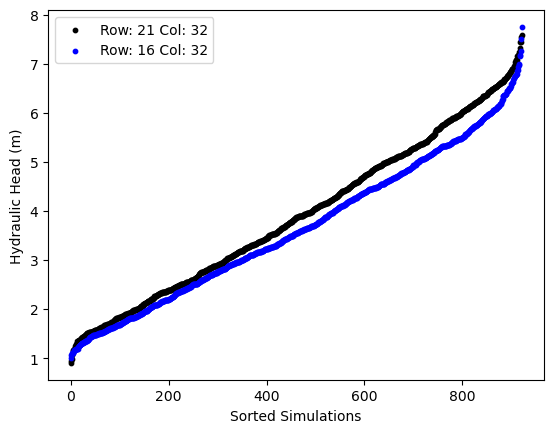

In [111]:
#Extra Plotting of well head data to examine head values in head difference cells 
#701 is row 18, col 32 
#605 is row 16, col 32 - commonly most important

wn = 701
wn = 845
print("well num, well col, well row, rf importance \n")
print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]),round(imp_df_rf.loc[str(wn)][0],3))

wn2 = 605
print("well num, well col, well row \n")
print(wn2,int(all_well_loc[wn2][0]), int(all_well_loc[wn2][1]),round(imp_df_rf.loc[str(wn2)][0],3))

label_str = "Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1])
label_str2 = "Row: " +str(all_well_loc[wn2][0])+ " Col: " + str(all_well_loc[wn2][1])

plt.scatter(range(len(LastStpHeads[str(wn)].index)),LastStpHeads[str(wn)].sort_values(), s = 10, c='k', label = label_str)
plt.scatter(range(len(LastStpHeads[str(wn2)].index)),LastStpHeads[str(wn2)].sort_values(), s = 10, c='b',label= label_str2)

plt.xlabel('Sorted Simulations')
plt.ylabel('Hydraulic Head (m)')
#plt.title("Location Head Values across All Steady State Simulations")# \n at Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1]))
plt.legend()
plt.show()
          

Low_K_ratio


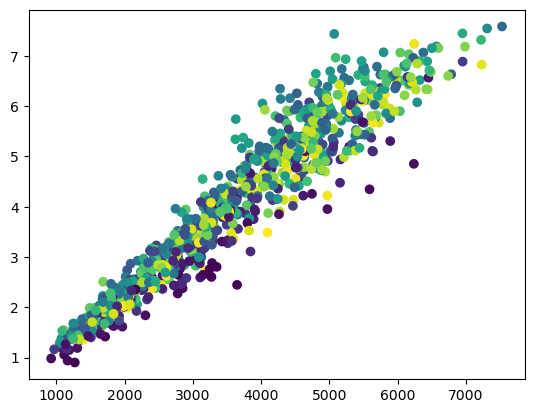

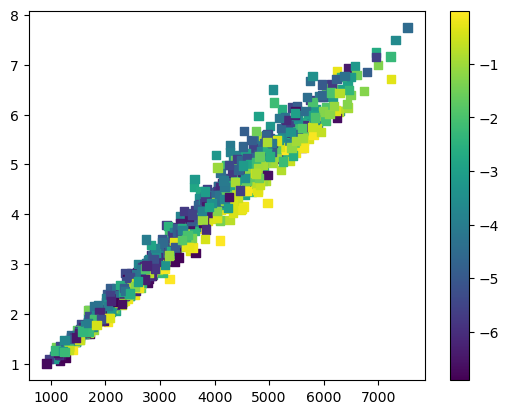

Sy


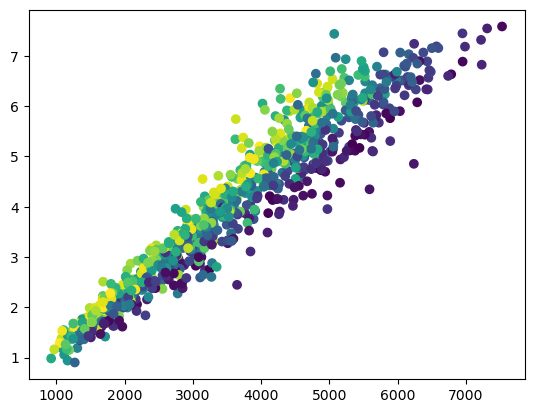

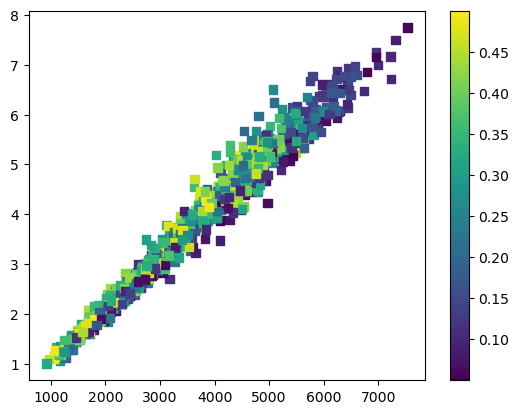

Rech


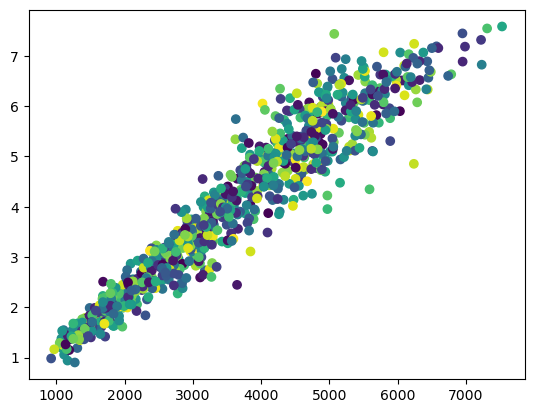

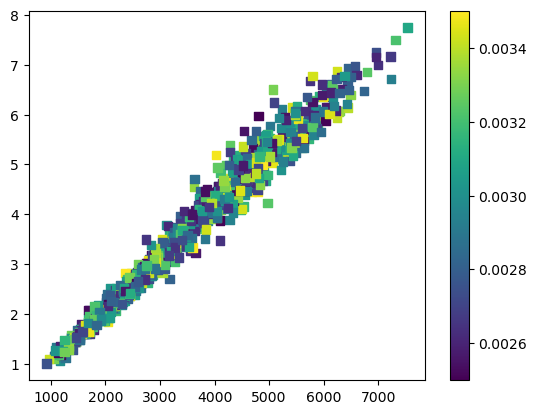

ET_valley


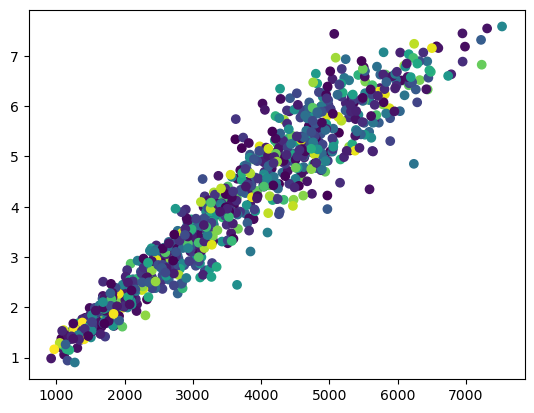

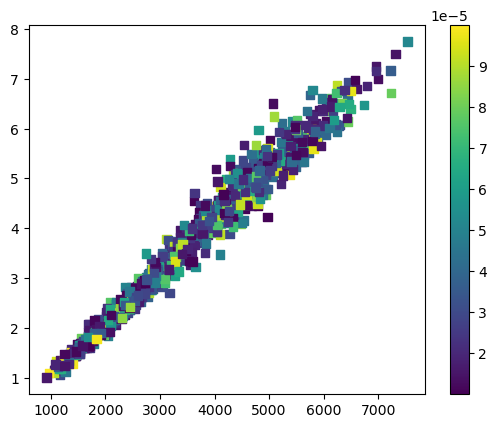

ET_rip_ratio


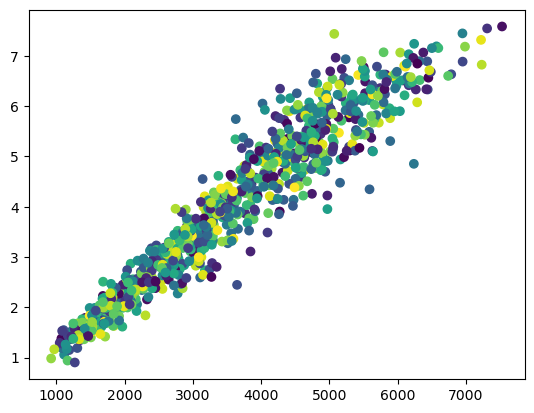

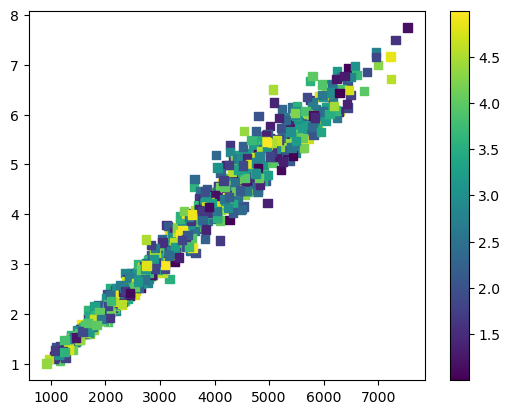

Stream_K_ratio


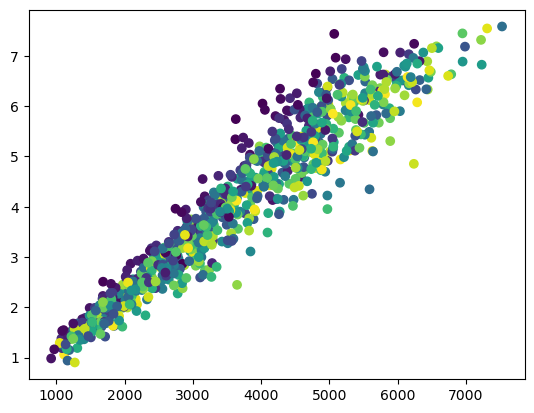

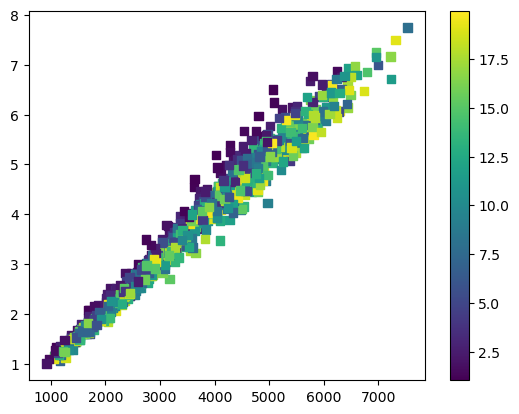

Pumping Rate


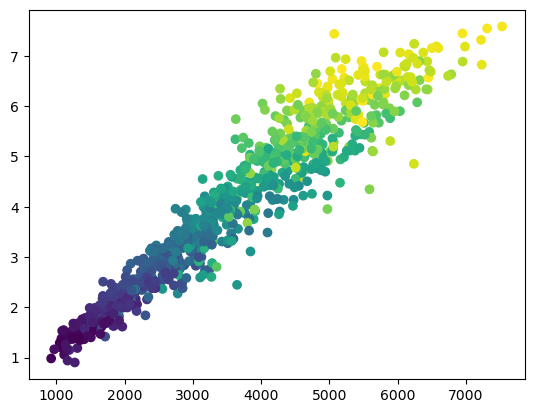

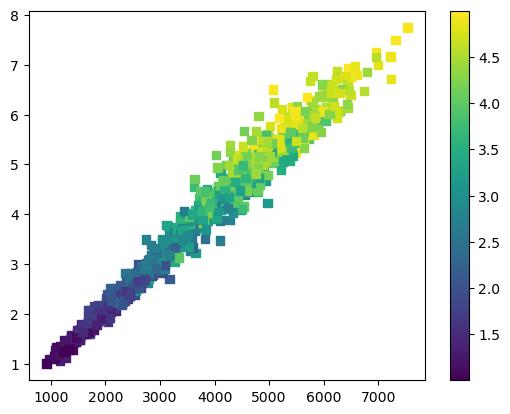

In [121]:
#PLotting outputs above with outflows 
#display(pardf)
for i in pardf.columns[1:]:
    print(i)
    if i == 'Low_K_ratio':
        z = np.log(pardf[i])
    else:
        z = pardf[i]
    plt.scatter(outputsdf[rn],LastStpHeads[str(wn)], c=z, cmap=cm.viridis)
    plt.show()
    
    plt.scatter(outputsdf[rn],LastStpHeads[str(wn2)],marker='s', c=z, cmap=cm.viridis)
    cbar = plt.colorbar()
    plt.show()
#plt.scatter(outputsdf[rn],LastStpHeads[str(wn)],c=pardf['Pumping Rate'], cmap=cm.hsv)
#cbar= plt.colorbar()
